In [ ]:
#import sys
#print(sys.executable)


c:\Users\gayat\anaconda3\envs\news_nlp\python.exe


In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

from sklearn.metrics import classification_report, confusion_matrix
import json


In [3]:
train_dir = r"E:\Fish\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\train"
val_dir   = r"E:\Fish\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\val"
test_dir  = r"E:\Fish\Dataset\images.cv_jzk6llhf18tm3k0kyttxz\data\test"


In [4]:

print(os.listdir(train_dir))


['animal fish', 'animal fish bass', 'fish sea_food black_sea_sprat', 'fish sea_food gilt_head_bream', 'fish sea_food hourse_mackerel', 'fish sea_food red_mullet', 'fish sea_food red_sea_bream', 'fish sea_food sea_bass', 'fish sea_food shrimp', 'fish sea_food striped_red_mullet', 'fish sea_food trout']


In [ ]:
IMG_SIZE = 224      #setting basic values # every image will be resized to 224x224 pixels
BATCH_SIZE = 32     #the model will look at 32 images at the same time
seed = 42           #makes sure the results stay the same every time we run the code

train_gen = ImageDataGenerator(
    rescale=1.0/255.,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,           #we do this to prevent overfitting 
    horizontal_flip=True        #helps the model learn better because it sees more variety
)

val_gen = ImageDataGenerator(
    rescale=1.0/255.
)                              #Validation and test images are not changed.We only scale them to 0–1.

test_gen = ImageDataGenerator(
    rescale=1.0/255.
)

#loading images from folders
train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=seed
)

val_data = val_gen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)
# to see how each fish type is mapped to a number
num_classes = train_data.num_classes
class_indices = train_data.class_indices

print("Classes:", class_indices)


Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.
Classes: {'animal fish': 0, 'animal fish bass': 1, 'fish sea_food black_sea_sprat': 2, 'fish sea_food gilt_head_bream': 3, 'fish sea_food hourse_mackerel': 4, 'fish sea_food red_mullet': 5, 'fish sea_food red_sea_bream': 6, 'fish sea_food sea_bass': 7, 'fish sea_food shrimp': 8, 'fish sea_food striped_red_mullet': 9, 'fish sea_food trout': 10}


In [ ]:
# SAVING CLASS INDICES FOR STREAMLIT

with open("class_indices.json", "w") as f:
    json.dump(class_indices, f)


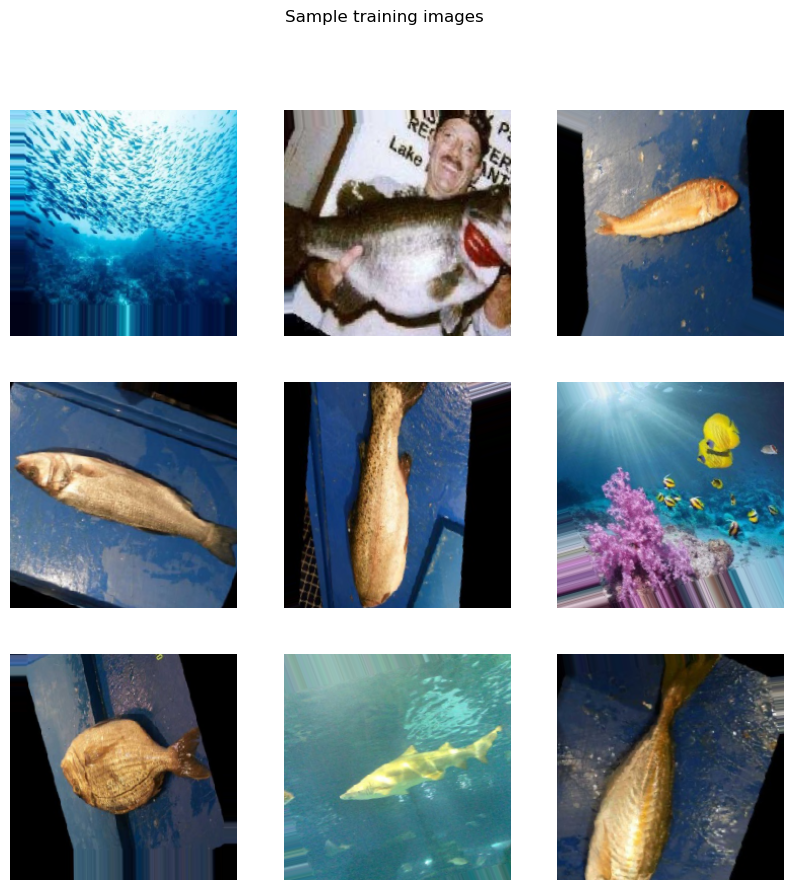

In [ ]:
# VISUALISING SOME TRAINING IMAGE

x_batch, y_batch = next(train_data)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])
    plt.axis("off")
plt.suptitle("Sample training images")
plt.show()


In [ ]:
# BUILDING AND TRAINING CNN FROM SCRATCH

cnn_model = models.Sequential()     #creating a model where layers are added one after another

cnn_model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

#First Convolution + Pooling
cnn_model.add(layers.Conv2D(32, (3, 3), activation="relu"))         #ReLU: Helps the model learn faster
cnn_model.add(layers.MaxPooling2D((2, 2)))      #MaxPooling: Reduces the size of the image to make learning easier

#Second Convolution + Pooling       Now the model learns more complex patterns
cnn_model.add(layers.Conv2D(64, (3, 3), activation="relu")) 
cnn_model.add(layers.MaxPooling2D((2, 2)))      

#Third Convolution + Pooling        Now the model learns even more detailed features
cnn_model.add(layers.Conv2D(128, (3, 3), activation="relu"))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(128, activation="relu"))
cnn_model.add(layers.Dropout(0.5))
cnn_model.add(layers.Dense(num_classes, activation="softmax"))

#Compiling the model
cnn_model.compile(
    optimizer="adam",   #A popular optimizer that helps the model learn
    loss="categorical_crossentropy",    #Loss function for multiclass problems
    metrics=["accuracy"]        #to measure how many predictions are correct
)

cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,379 (42.61 MB)

 Trainable params: 11,170,379 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#TRAIN
#It learns slowly, so need more epochs(10-20)
epochs_cnn = 10

history_cnn = cnn_model.fit(
    train_data,
    epochs=epochs_cnn,
    validation_data=val_data
)
'''
In this cell, I trained my CNN model for 10 epochs.
One epoch means the model sees all training images once.
Since CNNs trained from scratch learn slowly, I chose 10 epochs to give the model enough time to learn.
During training, the model learns from the training data and 
checks its performance on the validation data after each epoch.
The training history, including accuracy and loss, is stored in history_cnn for later analysis.
'''

c:\Users\gayat\anaconda3\envs\news_nlp\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 604s 3s/step - accuracy: 0.3385 - loss: 1.8754 - val_accuracy: 0.4872 - val_loss: 1.4096
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.5214 - loss: 1.3487 - val_accuracy: 0.6941 - val_loss: 0.9131
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 463s 2s/step - accuracy: 0.6223 - loss: 1.0662 - val_accuracy: 0.7537 - val_loss: 0.7113
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.7027 - loss: 0.8450 - val_accuracy: 0.8718 - val_loss: 0.4641
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - accuracy: 0.7410 - loss: 0.7331 - val_accuracy: 0.8571 - val_loss: 0.4251
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.7855 - loss: 0.6171 - val_accuracy: 0.9066 - val_loss: 0.3410
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.7958 - loss: 0.5749 - val_accuracy: 0.9066 - val_loss: 0.3128
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.8149 - loss: 0.5075 - val_accu

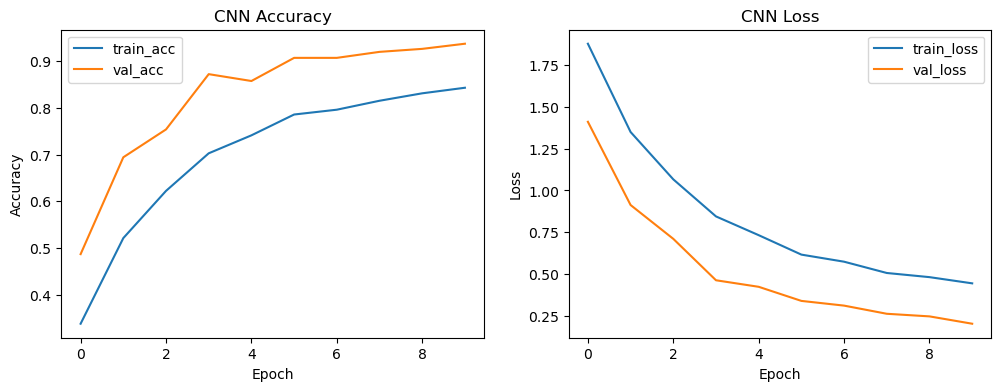

In [ ]:
# PLOTING THE TRAINING CURVES
#To know  if my model is learning well or making mistakes, and whether it is overfitting
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history["accuracy"], label="train_acc")
plt.plot(history_cnn.history["val_accuracy"], label="val_acc")
plt.title("CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history["loss"], label="train_loss")
plt.plot(history_cnn.history["val_loss"], label="val_loss")
plt.title("CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


#The first graph shows how good my model’s predictions are as it learns.
#The second graph shows how many mistakes the model is making.

35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 343ms/step - accuracy: 0.9368 - loss: 0.2048
CNN - Val Loss: 0.2048284262418747
CNN - Val Accuracy: 0.9368131756782532
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 415ms/step
Classification Report - CNN


c:\Users\gayat\anaconda3\envs\news_nlp\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\gayat\anaconda3\envs\news_nlp\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\gayat\anaconda3\envs\news_nlp\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

                                  precision    recall  f1-score   support

                     animal fish       0.95      1.00      0.97       187
                animal fish bass       0.00      0.00      0.00        10
   fish sea_food black_sea_sprat       0.98      1.00      0.99       105
   fish sea_food gilt_head_bream       0.73      0.83      0.78        94
   fish sea_food hourse_mackerel       0.99      1.00      0.99        97
        fish sea_food red_mullet       1.00      1.00      1.00        90
     fish sea_food red_sea_bream       0.95      0.66      0.78       113
          fish sea_food sea_bass       0.86      0.98      0.92        97
            fish sea_food shrimp       0.98      1.00      0.99       100
fish sea_food striped_red_mullet       0.99      0.97      0.98       101
             fish sea_food trout       0.95      1.00      0.98        98

                        accuracy                           0.94      1092
                       macro avg    

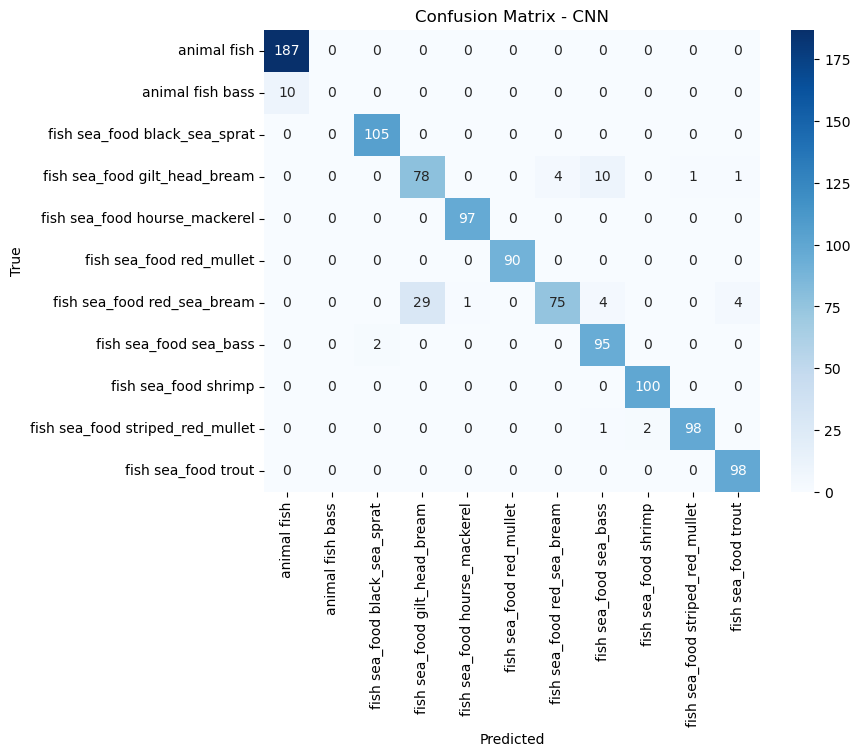

In [ ]:
#EVALUATING ON VALIDATION SET
'''
checking how well my CNN model performs on the validation set.
First, I calculated the overall accuracy and loss.
Then I compared the actual fish labels with the predicted ones.
'''
val_data.reset()
cnn_val_loss, cnn_val_acc = cnn_model.evaluate(val_data)
print("CNN - Val Loss:", cnn_val_loss)
print("CNN - Val Accuracy:", cnn_val_acc)

y_true_val = val_data.classes
y_pred_probs_cnn = cnn_model.predict(val_data)
y_pred_cnn = np.argmax(y_pred_probs_cnn, axis=1)

print("Classification Report - CNN")
print(classification_report(y_true_val, y_pred_cnn, target_names=list(class_indices.keys())))

cm_cnn = confusion_matrix(y_true_val, y_pred_cnn)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_cnn,
    annot=True,
    fmt="d",
    xticklabels=list(class_indices.keys()),
    yticklabels=list(class_indices.keys()),
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CNN")
plt.show()

#This helps me understand the strengths and weaknesses of my model

In [14]:
# SAVE CNN

cnn_model.save("cnn_fish_model.h5")


In [ ]:
# TRANSFER LEARNING - VGG16( image classification)


base_vgg = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

for layer in base_vgg.layers:           #freeze all the layers so they don’t change during training.
    layer.trainable = False

vgg_model = models.Sequential()
vgg_model.add(base_vgg)
vgg_model.add(layers.GlobalAveragePooling2D())
vgg_model.add(layers.Dense(256, activation="relu"))#added a dense layer to learn new patterns specific to fish dataset.
vgg_model.add(layers.Dropout(0.5))
vgg_model.add(layers.Dense(num_classes, activation="softmax")) #This predicts which fish type the image belongs to.

vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

vgg_model.summary()

#“I reused VGG16’s pretrained knowledge, froze it, 
# added my own layers for my 11 fish classes, and trained only the new layers.”

In [ ]:
img_height = 224
img_width = 224
#tell the model what size our input images should be.

In [20]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Load pretrained VGG16
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False  # freeze convolution layers

# Build your model
vgg_model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

# Compile
vgg_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step


In [ ]:
#TRAIN

epochs_tl = 8

history_vgg = vgg_model.fit(
    train_data,
    epochs=epochs_tl,
    validation_data=val_data
)

'''
“In this cell, I trained my VGG16 transfer learning model for 8 epochs.
The model learns from the training images and checks its accuracy on the validation images after each epoch.
The training history is saved in history_vgg so I can plot the accuracy and loss later.”
'''

Epoch 1/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 2157s 11s/step - accuracy: 0.4590 - loss: 1.6616 - val_accuracy: 0.8168 - val_loss: 0.7595
Epoch 2/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 2215s 11s/step - accuracy: 0.6146 - loss: 1.0355 - val_accuracy: 0.9002 - val_loss: 0.4739
Epoch 3/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 2117s 11s/step - accuracy: 0.6718 - loss: 0.8732 - val_accuracy: 0.9304 - val_loss: 0.3317
Epoch 4/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 2194s 11s/step - accuracy: 0.7219 - loss: 0.7396 - val_accuracy: 0.9423 - val_loss: 0.2313
Epoch 5/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 2151s 11s/step - accuracy: 0.7390 - loss: 0.6736 - val_accuracy: 0.9487 - val_loss: 0.2666
Epoch 6/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 2149s 11s/step - accuracy: 0.7499 - loss: 0.6465 - val_accuracy: 0.9643 - val_loss: 0.1602
Epoch 7/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 2209s 11s/step - accuracy: 0.7757 - loss: 0.5925 - val_accuracy: 0.9661 - val_loss: 0.1601
Epoch 8/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 2238s 11s/step - accuracy: 0.7865 - loss: 0.5606 - 

In [ ]:

# Saving the trained model 
vgg_model.save("vgg16_transfer_model.h5")

35/35 ━━━━━━━━━━━━━━━━━━━━ 294s 8s/step - accuracy: 0.9698 - loss: 0.1321
VGG16 - Val Loss: 0.13213662803173065
VGG16 - Val Accuracy: 0.9697802066802979
35/35 ━━━━━━━━━━━━━━━━━━━━ 336s 9s/step
Classification Report - VGG16


c:\Users\gayat\anaconda3\envs\news_nlp\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\gayat\anaconda3\envs\news_nlp\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\gayat\anaconda3\envs\news_nlp\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

                                  precision    recall  f1-score   support

                     animal fish       0.95      0.99      0.97       187
                animal fish bass       0.00      0.00      0.00        10
   fish sea_food black_sea_sprat       0.95      1.00      0.97       105
   fish sea_food gilt_head_bream       0.95      0.99      0.97        94
   fish sea_food hourse_mackerel       1.00      1.00      1.00        97
        fish sea_food red_mullet       0.94      0.99      0.96        90
     fish sea_food red_sea_bream       0.98      0.96      0.97       113
          fish sea_food sea_bass       0.99      0.94      0.96        97
            fish sea_food shrimp       1.00      1.00      1.00       100
fish sea_food striped_red_mullet       0.97      0.91      0.94       101
             fish sea_food trout       1.00      1.00      1.00        98

                        accuracy                           0.97      1092
                       macro avg    

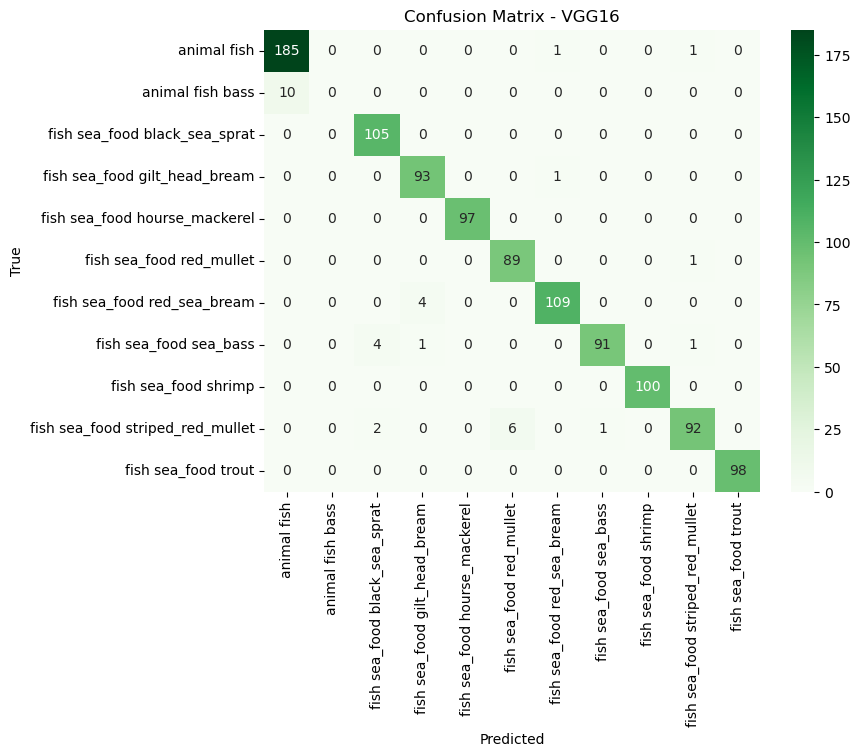

In [ ]:
#EVALUATE

val_data.reset()
vgg_val_loss, vgg_val_acc = vgg_model.evaluate(val_data)
print("VGG16 - Val Loss:", vgg_val_loss)
print("VGG16 - Val Accuracy:", vgg_val_acc)

y_pred_probs_vgg = vgg_model.predict(val_data)
y_pred_vgg = np.argmax(y_pred_probs_vgg, axis=1)

print("Classification Report - VGG16")
print(classification_report(y_true_val, y_pred_vgg, target_names=list(class_indices.keys())))

cm_vgg = confusion_matrix(y_true_val, y_pred_vgg)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_vgg,
    annot=True,
    fmt="d",
    xticklabels=list(class_indices.keys()),
    yticklabels=list(class_indices.keys()),
    cmap="Greens"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - VGG16")
plt.show()



#“VGG16 gives 97% accuracy and predicts almost all fish types correctly, except one class with very few images.”

In [ ]:
# TRANSFER LEARNING- ResNet50
#reused ResNet50’s pretrained knowledge, added my own layers for my fish classes, and trained only those new layers
base_resnet = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

for layer in base_resnet.layers:
    layer.trainable = False

resnet_model = models.Sequential()
resnet_model.add(base_resnet)
resnet_model.add(layers.GlobalAveragePooling2D())#makes ResNet output smaller and easier to use
resnet_model.add(layers.Dense(256, activation="relu"))#learns new patterns for your fish dataset
resnet_model.add(layers.Dropout(0.5))#prevents overfitting
resnet_model.add(layers.Dense(num_classes, activation="softmax"))#final layer that predicts your fish type

resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

resnet_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 91s 1us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,115,083 (91.99 MB)

 Trainable params: 527,371 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 1015s 4s/step - accuracy: 0.1430 - loss: 2.4319 - val_accuracy: 0.1712 - val_loss: 2.2641
Epoch 2/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 832s 4s/step - accuracy: 0.1759 - loss: 2.2799 - val_accuracy: 0.1712 - val_loss: 2.2308
Epoch 3/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 710s 4s/step - accuracy: 0.1902 - loss: 2.2425 - val_accuracy: 0.1786 - val_loss: 2.1935
Epoch 4/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 683s 4s/step - accuracy: 0.1891 - loss: 2.2162 - val_accuracy: 0.1630 - val_loss: 2.1682
Epoch 5/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 3272s 17s/step - accuracy: 0.2039 - loss: 2.1934 - val_accuracy: 0.2253 - val_loss: 2.1472
Epoch 6/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 630s 3s/step - accuracy: 0.2127 - loss: 2.1688 - val_accuracy: 0.2418 - val_loss: 2.1168
Epoch 7/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 660s 3s/step - accuracy: 0.2183 - loss: 2.1493 - val_accuracy: 0.2628 - val_loss: 2.0931
Epoch 8/8
195/195 ━━━━━━━━━━━━━━━━━━━━ 682s 3s/step - accuracy: 0.2297 - loss: 2.1257 - val_accuracy:

c:\Users\gayat\anaconda3\envs\news_nlp\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\gayat\anaconda3\envs\news_nlp\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\gayat\anaconda3\envs\news_nlp\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

                                  precision    recall  f1-score   support

                     animal fish       0.24      0.77      0.36       187
                animal fish bass       0.00      0.00      0.00        10
   fish sea_food black_sea_sprat       0.50      0.01      0.02       105
   fish sea_food gilt_head_bream       0.00      0.00      0.00        94
   fish sea_food hourse_mackerel       0.38      0.35      0.37        97
        fish sea_food red_mullet       0.21      0.59      0.31        90
     fish sea_food red_sea_bream       0.00      0.00      0.00       113
          fish sea_food sea_bass       1.00      0.01      0.02        97
            fish sea_food shrimp       0.00      0.00      0.00       100
fish sea_food striped_red_mullet       0.29      0.34      0.31       101
             fish sea_food trout       0.44      0.11      0.18        98

                        accuracy                           0.25      1092
                       macro avg    

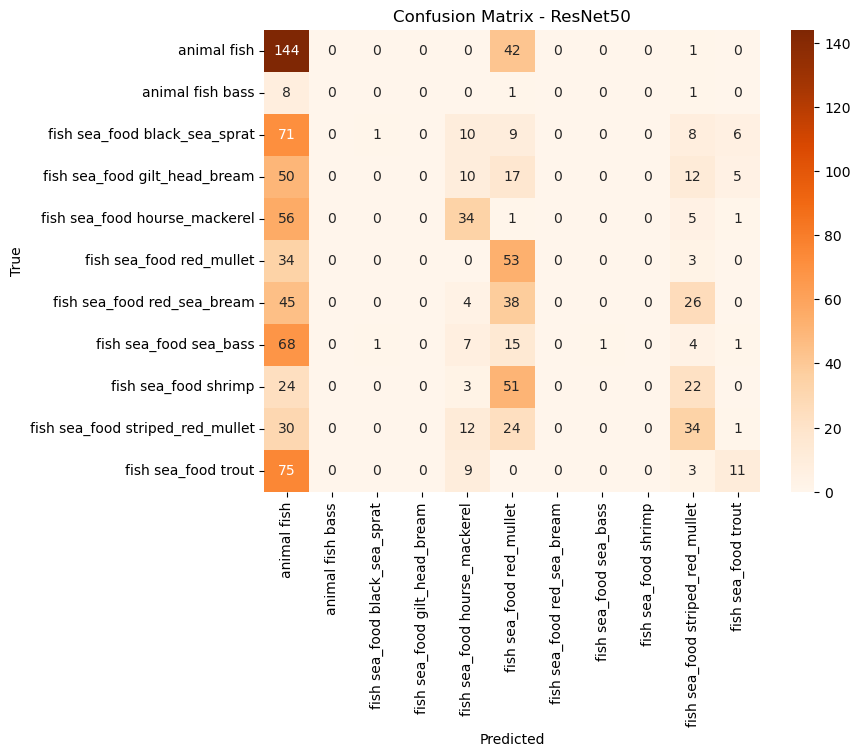

In [ ]:
# TRAIN AND EVALUATE
'''
This code trains the ResNet50 model, checks its accuracy on the validation data, prints the classification report,
and shows a confusion matrix to see which fish types were predicted correctly or incorrectly.
'''

history_resnet = resnet_model.fit(
    train_data,
    epochs=epochs_tl,
    validation_data=val_data
)

val_data.reset()
resnet_val_loss, resnet_val_acc = resnet_model.evaluate(val_data)
print("ResNet50 - Val Loss:", resnet_val_loss)
print("ResNet50 - Val Accuracy:", resnet_val_acc)

y_pred_probs_resnet = resnet_model.predict(val_data)
y_pred_resnet = np.argmax(y_pred_probs_resnet, axis=1)

print("Classification Report - ResNet50")
print(classification_report(y_true_val, y_pred_resnet, target_names=list(class_indices.keys())))

cm_resnet = confusion_matrix(y_true_val, y_pred_resnet)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_resnet,
    annot=True,
    fmt="d",
    xticklabels=list(class_indices.keys()),
    yticklabels=list(class_indices.keys()),
    cmap="Oranges"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - ResNet50")
plt.show()


In [25]:
# Saving the trained model
resnet_model.save("resnet50_transfer_model.h5")

In [27]:
# COMPARING THE MODEL AND PICKING THE BEST

model_results = [
    ("CNN", cnn_val_acc),
    ("VGG16", vgg_val_acc),
    ("ResNet50", resnet_val_acc)
]

for name, acc in model_results:
    print(name, "Validation Accuracy:", acc)

best_model_name = None
best_val_acc = -1
best_model = None

for name, acc in model_results:
    if acc > best_val_acc:
        best_val_acc = acc
        best_model_name = name

if best_model_name == "CNN":
    best_model = cnn_model
elif best_model_name == "VGG16":
    best_model = vgg_model
elif best_model_name == "ResNet50":
    best_model = resnet_model

print("Best model:", best_model_name, "with Val Accuracy:", best_val_acc)


CNN Validation Accuracy: 0.9368131756782532
VGG16 Validation Accuracy: 0.9697802066802979
ResNet50 Validation Accuracy: 0.25457876920700073
Best model: VGG16 with Val Accuracy: 0.9697802066802979


In [28]:
# SAVING THE BEST MODEL

best_model_filename = f"best_fish_model_{best_model_name}.h5"
best_model.save(best_model_filename)
print("Saved best model as:", best_model_filename)


Saved best model as: best_fish_model_VGG16.h5


In [29]:
# EVALUATING THE TEST SET

test_data.reset()
test_loss, test_acc = best_model.evaluate(test_data)
print("Best model:", best_model_name)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)


c:\Users\gayat\anaconda3\envs\news_nlp\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 1215s 10s/step - accuracy: 0.9746 - loss: 0.1070
Best model: VGG16
Test Loss: 0.10703679919242859
Test Accuracy: 0.9745842218399048


In [2]:
from tensorflow.keras.models import load_model
model = load_model("best_fish_model_VGG16.h5")



In [3]:
model.save("Fish_model.h5", save_format='h5')


In [ ]:
#*****************************************************************************************#

In [11]:
from tensorflow.keras.preprocessing.image import load_img
print(load_img)



<function load_img at 0x0000023C62838FE0>


In [13]:
from tensorflow.keras.utils import load_img, img_to_array
from keras.utils import load_img, img_to_array




In [16]:
from PIL import Image
from tensorflow.keras.utils import load_img, img_to_array

print("PIL:", Image)
print("Keras load_img:", load_img)
print("Keras img_to_array:", img_to_array)


PIL: <module 'PIL.Image' from 'c:\\Users\\gayat\\anaconda3\\envs\\news_nlp\\Lib\\site-packages\\PIL\\Image.py'>
Keras load_img: <function load_img at 0x0000023C62838FE0>
Keras img_to_array: <function img_to_array at 0x0000023C62764680>


In [14]:
print(train_data.image_shape)


(224, 224, 3)


In [15]:
import keras
print(keras.__file__)


c:\Users\gayat\anaconda3\envs\news_nlp\Lib\site-packages\keras\__init__.py
